In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from matplotlib.cbook import get_sample_data
from PIL import ImageFile
import os

In [0]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
image_size = 256
PATH = "/content/drive/My Drive/dataset/webtoon50"

In [0]:
data = datasets.ImageFolder(PATH,transform= transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        ]))

print(data.class_to_idx)

class_to_idx = data.class_to_idx
idx_to_class = {}
for key, value in enumerate(class_to_idx):
    idx_to_class[key] = value
    
print(idx_to_class)

img_list = []
for i in data.imgs:
    img_list.append(i[0])

img_list2 = []

for img in os.listdir('/content/drive/My Drive/dataset/thumnail'):
  img_list2.append(os.path.join('/content/drive/My Drive/dataset/thumnail',img))
img_list2.sort()

{'203호 저승사자': 0, '2인용 인간': 1, '8월의 눈보라': 2, 'Doll 체인지': 3, 'Here U Are D': 4, '가령의 정체불명 이야기': 5, '가비지타임': 6, '가슴털 로망스': 7, '가타부타타': 8, '간 떨어지는 동거': 9, '갓 오브 하이스쿨': 10, '갓!김치': 11, '갓도령스': 12, '갓물주': 13, '같은도장': 14, '걸어서 30분': 15, '검은인간': 16, '겟라이프': 17, '격기3반': 18, '고래별': 19}
{0: '203호 저승사자', 1: '2인용 인간', 2: '8월의 눈보라', 3: 'Doll 체인지', 4: 'Here U Are D', 5: '가령의 정체불명 이야기', 6: '가비지타임', 7: '가슴털 로망스', 8: '가타부타타', 9: '간 떨어지는 동거', 10: '갓 오브 하이스쿨', 11: '갓!김치', 12: '갓도령스', 13: '갓물주', 14: '같은도장', 15: '걸어서 30분', 16: '검은인간', 17: '겟라이프', 18: '격기3반', 19: '고래별'}


In [0]:
resnet = models.resnet50(pretrained=True)

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        #self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        #self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        #out_4 = self.layer4(out_3)
        #out_5 = self.layer5(out_4)

        return out_0, out_1, out_2, out_3, # out_4, out_5

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

In [0]:
resnet = Resnet().cuda()
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
total_arr = []
label_arr = []

for idx,(image,label) in enumerate(data):
    i = image.cuda()
    i = i.view(-1,i.size()[0],i.size()[1],i.size()[2])

    style_target = list(GramMatrix().cuda()(i) for i in resnet(i))

    arr = torch.cat([style_target[0].view(-1),style_target[1].view(-1),style_target[2].view(-1),style_target[3].view(-1)],0)
    gram = arr.cpu().data.numpy().reshape(1,-1)

    total_arr.append(gram.reshape(-1))
    label_arr.append(label)

    if idx % 50 == 0 and idx != 0:
      print(f'{idx} images style feature extracted..[{round(idx / len(data), 2) * 100}%]')
print('\Image style feature extraction done.\')

50 images style feature extracted..[5.0%]
100 images style feature extracted..[10.0%]
150 images style feature extracted..[15.0%]
200 images style feature extracted..[20.0%]
250 images style feature extracted..[25.0%]
300 images style feature extracted..[30.0%]
350 images style feature extracted..[35.0%]
400 images style feature extracted..[40.0%]
450 images style feature extracted..[45.0%]
500 images style feature extracted..[50.0%]
550 images style feature extracted..[55.00000000000001%]
600 images style feature extracted..[60.0%]
650 images style feature extracted..[65.0%]
700 images style feature extracted..[70.0%]
750 images style feature extracted..[75.0%]
800 images style feature extracted..[80.0%]
850 images style feature extracted..[85.0%]
900 images style feature extracted..[90.0%]
950 images style feature extracted..[95.0%]


In [0]:
model = TSNE(n_components=2, init='pca',random_state=0, verbose=3, perplexity=100)
result = model.fit_transform(total_arr)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1000 samples in 38.262s...
[t-SNE] Computed neighbors for 1000 samples in 601.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 17869.690092
[t-SNE] Computed conditional probabilities in 0.353s
[t-SNE] Iteration 50: error = 48.4748459, gradient norm = 0.0006619 (50 iterations in 0.519s)
[t-SNE] Iteration 100: error = 47.6511307, gradient norm = 0.0003505 (50 iterations in 0.524s)
[t-SNE] Iteration 150: error = 47.1554146, gradient norm = 0.0002343 (50 iterations in 0.523s)
[t-SNE] Iteration 200: error = 46.8076210, gradient norm = 0.0001762 (50 iterations in 0.529s)
[t-SNE] Iteration 250: error = 46.5372543, gradient norm = 0.0001420 (50 iterations in 0.526s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.537254
[t-SNE] Iteration 300: error = 1.3892368, gradient norm = 0.0001376 (50 iterations in 0.524s)
[t-SNE] Iteration 350: error = 1.3767720, gradient norm =

In [0]:
def imscatter(x, y, image, ax=None, zoom=1, show_by_thumnail=False, title='webtoon'):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)

    # Convert inputs to arrays with at least one dimension.
    x, y = np.atleast_1d(x, y)
    
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        

        if show_by_thumnail:
          offsetbox = TextArea(title, minimumdescent=False)
          ac = AnnotationBbox(offsetbox, (x0, y0),
                      xybox=(20, -40),
                      xycoords='data',
                      boxcoords="offset points")
          artists.append(ax.add_artist(ac))
        artists.append(ax.add_artist(ab))

    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

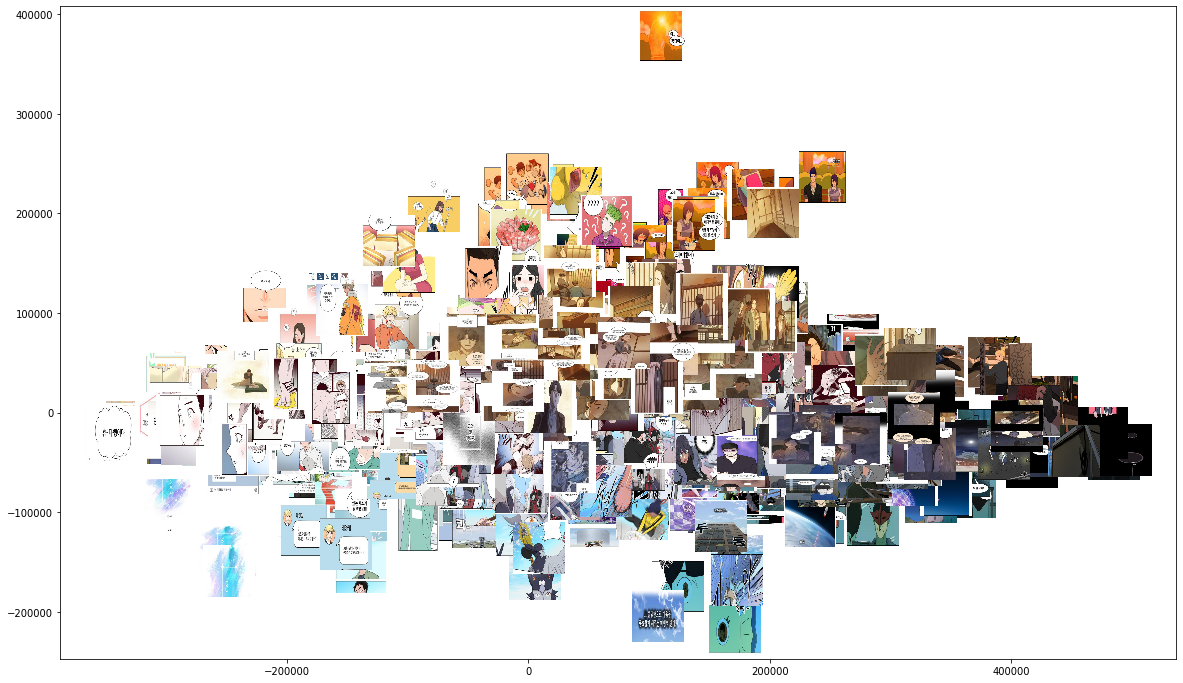

In [0]:
plt.figure(figsize=(20, 12))

for i in range(len(result)):
    img_path = img_list[i]
    imscatter(result[i,0],result[i,1], image=img_path, zoom=0.2)
plt.show()

In [0]:
avg_list = []
scatter_x = result[:, 0]
scatter_y = result[:, 1]
group = np.array(label_arr)

for g in np.unique(group):
  i = np.where(group==g)
  x_avg = np.mean(scatter_x[i])
  y_avg = np.mean(scatter_y[i])
  avg_list.append((x_avg, y_avg))

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s

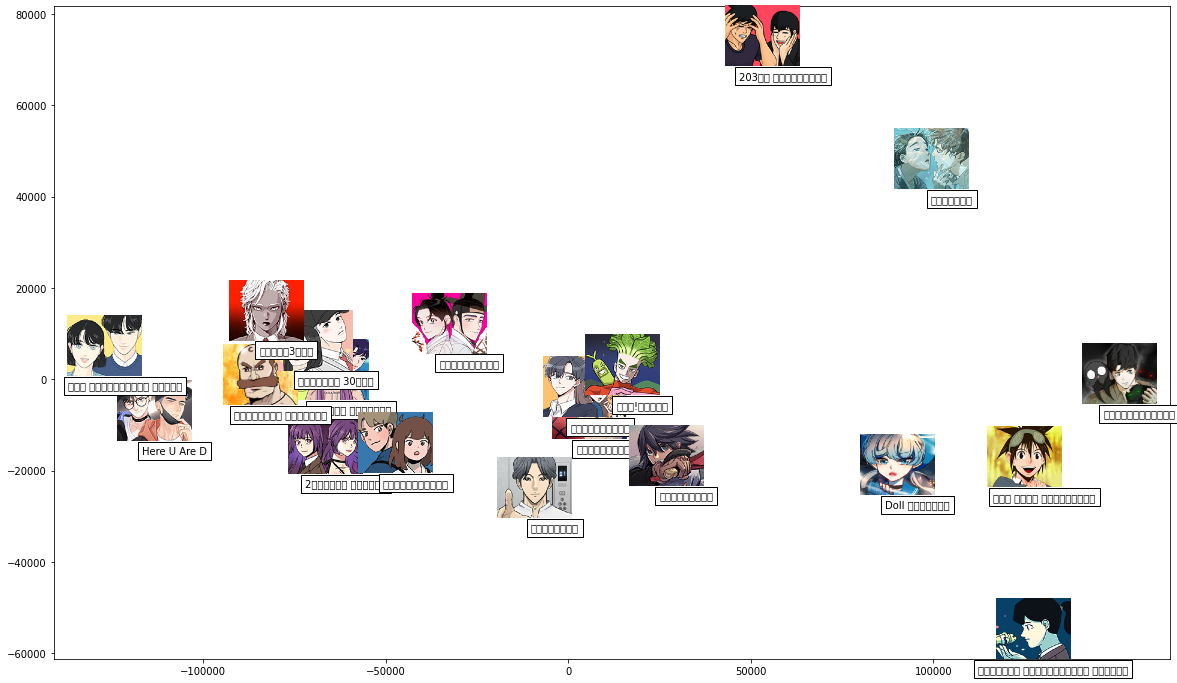

In [0]:
plt.figure(figsize=(20, 12))

for i in range(len(avg_list)):
    img_path = img_list2[i]
    imscatter(avg_list[i][0],avg_list[i][1], image=img_path,zoom=0.6, show_by_thumnail=True, title=idx_to_class[i])
plt.show()